# **Линейные модели, SVM и деревья решений**

# **Задание:**
Выберите набор данных (датасет) для решения задачи классификации или регрессии.

В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

С использованием метода train_test_split разделите выборку на обучающую и тестовую.

Обучите следующие модели:

одну из линейных моделей;

SVM;

дерево решений.

Оцените качество моделей с помощью трех подходящих для задачи метрик. Сравните качество полученных моделей.

Произведите для каждой модели подбор одного гиперпараметра с использованием GridSearchCV и кросс-валидации.

Повторите пункт 4 для найденных оптимальных значений гиперпараметров. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.

Дополнительные задания:

Проведите эксперименты с важностью признаков в дереве решений.

Визуализируйте дерево решений.

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
def make_dataframe(ds_function):
    ds = ds_function()
    df = pd.DataFrame(data= np.c_[ds['data'], ds['target']],
                     columns= list(ds['feature_names']) + ['target'])
    return df
from sklearn.datasets import fetch_california_housing
from sklearn.externals.six import StringIO
import graphviz 
import pydotplus
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
data = fetch_california_housing()

# **Датасет данных о жилье в Калифорнии(пропуски отсутствуют, нет категориальных признаков для кодирования):**

# **Разбиение выборки:**

In [3]:
df_california = pd.DataFrame(data.data,columns=data.feature_names)
df_california['target'] = pd.Series(data.target)
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


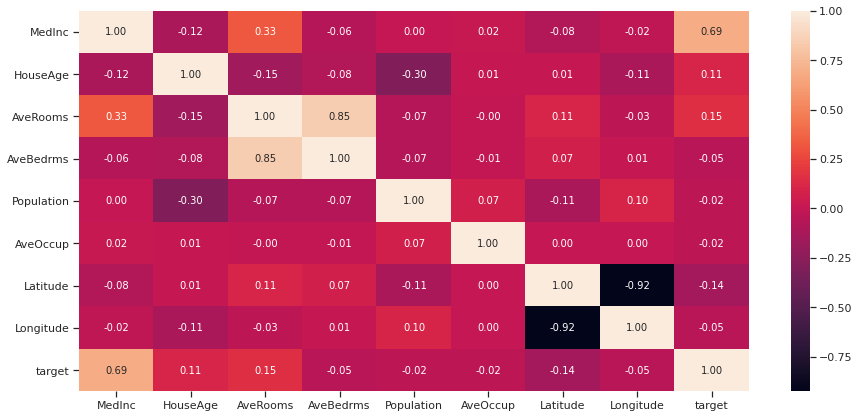

In [4]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_california.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

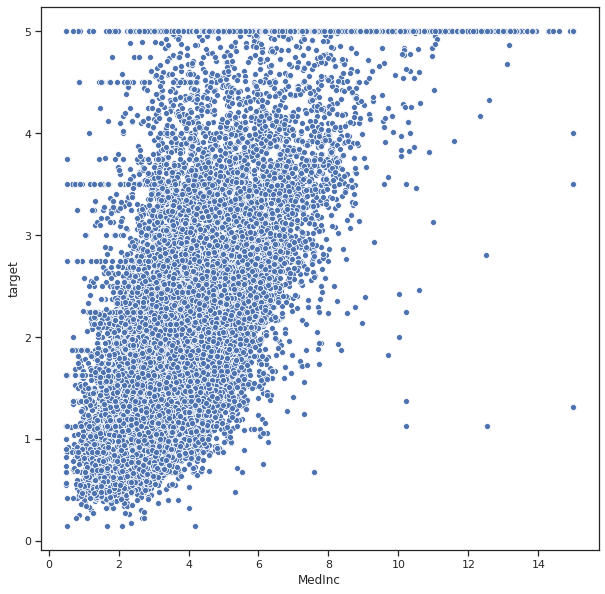

In [5]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(ax=ax, x='MedInc', y='target', data=df_california)

Между признаком "MedInc" и целевым признаком "target" существует зависимость, близкая к линейной, коэффициент корреляции = 0,69

Попробуем восстановить данную линейную зависимость.

аналитическое вычисление коэффициентов:

In [0]:
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [0]:
x_array = df_california['MedInc'].values
y_array = df_california['target'].values

In [8]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(0.45085576703268027, 0.41793849201896244)

In [0]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [0]:
y_array_regr = y_regr(x_array, b0, b1)

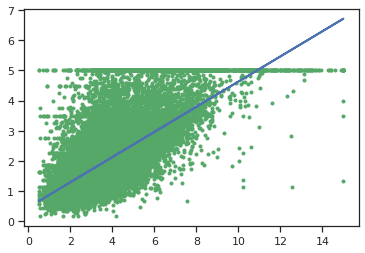

In [11]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

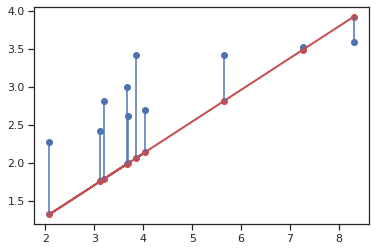

In [12]:
# Синими отрезками показаны ошибки между 
# истинными и предсказанными значениями
K_mnk=10

plt.plot(x_array[1:K_mnk+1], y_array[1:K_mnk+1], 'bo')
plt.plot(x_array[1:K_mnk+1], y_array_regr[1:K_mnk+1], '-ro', linewidth=2.0)

for i in range(len(x_array[1:K_mnk+1])):
    x1 = x_array[1:K_mnk+1][i]
    y1 = y_array[1:K_mnk+1][i]
    y2 = y_array_regr[1:K_mnk+1][i]
    plt.plot([x1,x1],[y1,y2],'b-')

plt.show()

In [0]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred
    

In [0]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = 0.45085576703268027 - (теоретический), 0.035046884360901316 - (градиентный спуск)
b1 = 0.41793849201896244 - (теоретический), 0.16024063837885774 - (градиентный спуск)
MSE = 2.237016080434203


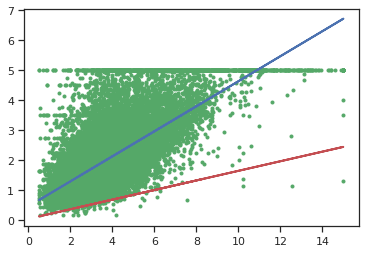

In [15]:
# Примеры использования градиентного спуска
show_gradient_descent(10, 0, 0)

b0 = 0.45085576703268027 - (теоретический), 0.21125447583768953 - (градиентный спуск)
b1 = 0.41793849201896244 - (теоретический), 0.46832724481210447 - (градиентный спуск)
MSE = 0.011149582877403865


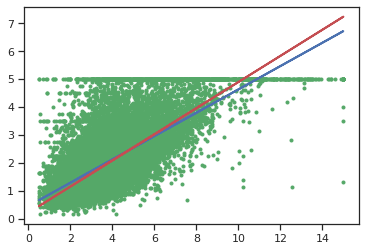

In [16]:
show_gradient_descent(1000, 0, 0)

b0 = 0.45085576703268027 - (теоретический), 0.4508557641340037 - (градиентный спуск)
b1 = 0.41793849201896244 - (теоретический), 0.4179384926285615 - (градиентный спуск)
MSE = 1.6318485911138797e-18


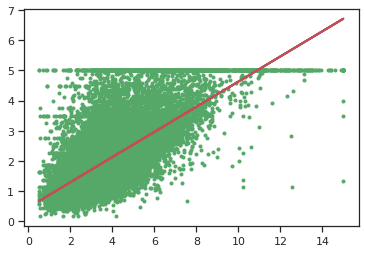

In [17]:
show_gradient_descent(50000, 0, 0)

b0 = 0.45085576703268027 - (теоретический), 0.45085576703259417 - (градиентный спуск)
b1 = 0.41793849201896244 - (теоретический), 0.41793849201898114 - (градиентный спуск)
MSE = 1.4521197259897182e-27


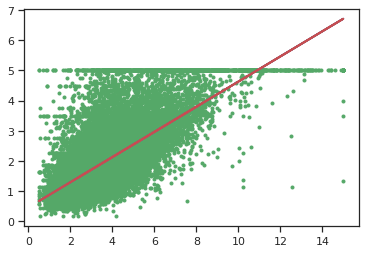

In [18]:
show_gradient_descent(100000, 0, 0)

b0 = 0.45085576703268027 - (теоретический), 0.45085576703259417 - (градиентный спуск)
b1 = 0.41793849201896244 - (теоретический), 0.41793849201898114 - (градиентный спуск)
MSE = 1.4521197259897182e-27


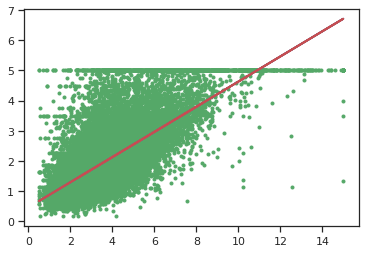

In [19]:
show_gradient_descent(1000000, 0, 0)

b0 = 0.45085576703268027 - (теоретический), -20.286696565576065 - (градиентный спуск)
b1 = 0.41793849201896244 - (теоретический), 4.779097786324618 - (градиентный спуск)
MSE = 83.52092622146682


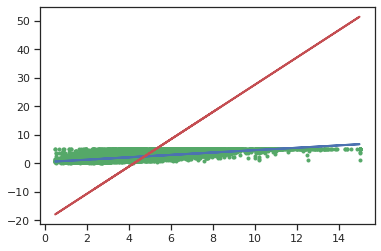

In [20]:
show_gradient_descent(1000, -30, 5)

b0 = 0.45085576703268027 - (теоретический), 0.45085576703259417 - (градиентный спуск)
b1 = 0.41793849201896244 - (теоретический), 0.41793849201898114 - (градиентный спуск)
MSE = 1.4521197259897182e-27


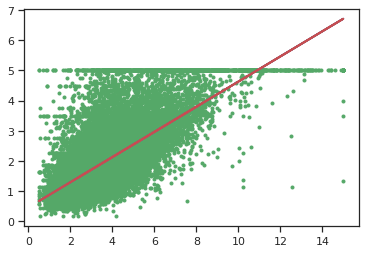

In [21]:
show_gradient_descent(100000, -30, 5)

# **Линейная регрессия при помощи библиотеки scikit-learn**

In [0]:
california_x_columns = ['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [23]:
# Обучим линейную регрессию и сравним коэффициенты с рассчитанными ранее
reg1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, reg1.coef_), (b0, reg1.intercept_)

((0.41793849201896244, array([[0.41793849]])),
 (0.45085576703268027, array([0.45085577])))

In [0]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(df_california[california_x_columns])

In [0]:
scoring = {'MAE': 'neg_mean_absolute_error', 
           'MSE': 'neg_mean_squared_error',
           'R2': 'r2'}

In [26]:
scores_3 = cross_validate(LinearRegression(), 
                        sc1_data, df_california['target'], scoring=scoring, 
                        cv=3, return_train_score=True)
scores_3

{'fit_time': array([0.00827169, 0.00720763, 0.00623298]),
 'score_time': array([0.00176811, 0.00223017, 0.00171518]),
 'test_MAE': array([-0.57887213, -0.50877351, -0.56305949]),
 'test_MSE': array([-0.59988822, -0.49188049, -0.59155481]),
 'test_R2': array([0.55502126, 0.58837838, 0.58544641]),
 'train_MAE': array([-0.51394065, -0.54832542, -0.52079949]),
 'train_MSE': array([-0.49933994, -0.54483711, -0.50929041]),
 'train_R2': array([0.62059396, 0.61067588, 0.59991471])}

# **Данные метрик линейной регрессии для сравнения с другими моделями**

In [27]:
-np.mean(scores_3['train_MAE']), -np.mean(scores_3['test_MAE']), \
-np.mean(scores_3['train_MSE']), -np.mean(scores_3['test_MSE']), \
np.mean(scores_3['train_R2']), np.mean(scores_3['test_R2'])

(0.5276885217738251,
 0.5502350422781422,
 0.5178224843539592,
 0.5611078368165351,
 0.6103948517000314,
 0.5762820158960761)

In [28]:
# Для небольшой выборки качество обучения сильно уступает нестохастическому градиентному спуску.
print('Размер выборки - {}'.format(x_array.shape[0]))
reg2 = SGDRegressor().fit(x_array.reshape(-1, 1), y_array)
(b1, reg2.coef_), (b0, reg2.intercept_)

Размер выборки - 20640


((0.41793849201896244, array([0.42488581])),
 (0.45085576703268027, array([0.45235938])))

In [0]:
from sklearn.linear_model import Lasso

In [30]:
reg3 = Lasso().fit(x_array.reshape(-1, 1), y_array)
(b1, reg3.coef_), (b0, reg3.intercept_)

((0.41793849201896244, array([0.14086477])),
 (0.45085576703268027, 1.5233170059994505))

In [0]:
from sklearn.linear_model import Ridge

In [32]:
reg4 = Ridge().fit(x_array.reshape(-1, 1), y_array)
(b1, reg4.coef_), (b0, reg4.intercept_)

((0.41793849201896244, array([0.41793288])),
 (0.45085576703268027, 0.4508774829636899))

In [0]:
from sklearn.linear_model import ElasticNet

In [34]:
reg5 = ElasticNet().fit(x_array.reshape(-1, 1), y_array)
(b1, reg5.coef_), (b0, reg5.intercept_)

((0.41793849201896244, array([0.24540411])),
 (0.45085576703268027, 1.1186795859141516))

# **Машина опорных векторов**

# **Реализация в коде**

In [0]:
california_x = df_california['MedInc'].values
california_y = df_california['target'].values

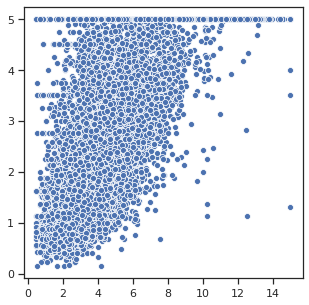

In [36]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=california_x, y=california_y)

In [0]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(california_x.reshape(-1, 1), california_y)
    california_y_pred = clf.predict(california_x.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(california_x, california_y, 'b.')
    ax.plot(california_x, california_y_pred, 'ro')
    plt.show()

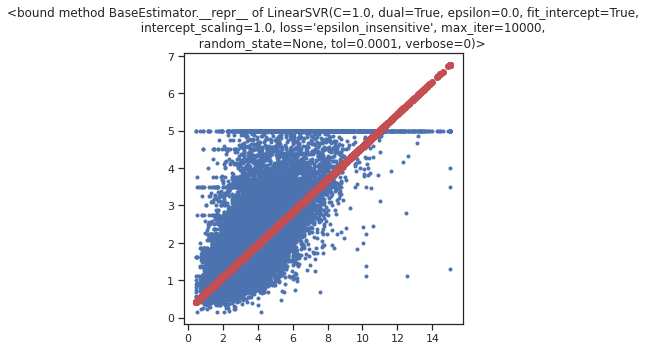

In [38]:
plot_regr(LinearSVR(C=1.0, max_iter=10000))

In [0]:
#plot_regr(LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=10000))

In [0]:
#plot_regr(SVR(kernel='linear', C=1.0))

In [0]:
#plot_regr(SVR(kernel='rbf', gamma=0.2, C=1.0))

In [0]:
#plot_regr(SVR(kernel='rbf', gamma=0.8, C=1.0))

In [0]:
#plot_regr(NuSVR(kernel='rbf', gamma=0.8, nu=0.1, C=1.0))

In [0]:
#plot_regr(NuSVR(kernel='rbf', gamma=0.8, nu=0.9, C=1.0))

In [0]:
#plot_regr(SVR(kernel='poly', degree=2, gamma='auto', C=1.0))

In [0]:
#plot_regr(SVR(kernel='poly', degree=3, gamma=0.2, C=1.0))

In [0]:
#plot_regr(SVR(kernel='poly', degree=4, gamma=0.2, C=1.0))

In [48]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [0]:
california_x_columns = ['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [50]:
# Диапазоны значений достаточно сильно различаются
df_california[california_x_columns].describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


**Модель без масштабирования данных**

In [51]:
california_X_train_1, california_X_test_1, california_y_train_1, california_y_test_1 = train_test_split(
    df_california[california_x_columns], df_california['target'], test_size=0.2, random_state=1)

california_X_train_1.shape, california_X_test_1.shape

((16512, 8), (4128, 8))

In [52]:
svr_1 = SVR()
svr_1.fit(california_X_train_1, california_y_train_1)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
california_y_pred_1 = svr_1.predict(california_X_test_1)

In [54]:
mean_absolute_error(california_y_test_1, california_y_pred_1), mean_squared_error(california_y_test_1, california_y_pred_1)

(0.8591093473587432, 1.320732383526986)

**Модель с масштабированием данных**

In [0]:
# Масштабирование данных в диапазоне от 0 до 1
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(df_california[california_x_columns])

In [56]:
sc1_data[:2]

array([[0.53966842, 0.78431373, 0.0435123 , 0.02046866, 0.00894083,
        0.00149943, 0.5674814 , 0.21115538],
       [0.53802706, 0.39215686, 0.03822395, 0.01892926, 0.0672104 ,
        0.00114074, 0.565356  , 0.21215139]])

In [57]:
california_X_train_2, california_X_test_2, california_y_train_2, california_y_test_2 = train_test_split(
    sc1_data, df_california['target'], test_size=0.2, random_state=1)

california_X_train_2.shape, california_X_test_2.shape

((16512, 8), (4128, 8))

In [58]:
svr_2 = SVR()
svr_2.fit(california_X_train_2, california_y_train_2)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
california_y_pred_2 = svr_2.predict(california_X_test_2)

In [60]:
mean_absolute_error(california_y_test_2, california_y_pred_2), mean_squared_error(california_y_test_2, california_y_pred_2)

(0.4505817514262831, 0.45299763645897284)

Эксперимент на основе кросс-валидации:

In [0]:
scoring = {'MAE': 'neg_mean_absolute_error', 
           'MSE': 'neg_mean_squared_error',
           'R2': 'r2'}

In [62]:
scores_1 = cross_validate(SVR(), 
                        df_california[california_x_columns], df_california['target'], scoring=scoring, 
                        cv=3, return_train_score=True)
scores_1

{'fit_time': array([12.11082315, 12.1236763 , 12.2641027 ]),
 'score_time': array([2.76550102, 2.76244593, 2.79872417]),
 'test_MAE': array([-0.88547721, -0.81302601, -0.95274753]),
 'test_MSE': array([-1.33180311, -1.2491849 , -1.59989289]),
 'test_R2': array([ 0.01210917, -0.04535864, -0.12118326]),
 'train_MAE': array([-0.86838827, -0.90060707, -0.83393092]),
 'train_MSE': array([-1.35236242, -1.40856087, -1.31120754]),
 'train_R2': array([-0.02754543, -0.00651499, -0.03005051])}

In [63]:
# Без масштабирования
-np.mean(scores_1['train_MAE']), -np.mean(scores_1['test_MAE']), \
-np.mean(scores_1['train_MSE']), -np.mean(scores_1['test_MSE'])

(0.8676420830790912, 0.8837502471655386, 1.3573769428582043, 1.393626970258224)

In [64]:
scores_2 = cross_validate(SVR(), 
                        sc1_data, df_california['target'], scoring=scoring, 
                        cv=3, return_train_score=True)
scores_2

{'fit_time': array([11.35171986, 11.65829659, 11.28841114]),
 'score_time': array([2.4718802 , 2.4750576 , 2.41563725]),
 'test_MAE': array([-0.51033856, -0.45036369, -0.56060072]),
 'test_MSE': array([-0.54870328, -0.433136  , -0.61684615]),
 'test_R2': array([0.59298868, 0.63753767, 0.56772258]),
 'train_MAE': array([-0.44006452, -0.46199119, -0.43109582]),
 'train_MSE': array([-0.43456878, -0.46134241, -0.42690641]),
 'train_R2': array([0.66980806, 0.67033867, 0.66463343])}

# **Данные метрик машины опорных векторов для сравнения с другими моделями**

In [65]:
# С масштабированием
-np.mean(scores_2['train_MAE']), -np.mean(scores_2['test_MAE']), \
-np.mean(scores_2['train_MSE']), -np.mean(scores_2['test_MSE']), \
np.mean(scores_2['train_R2']), np.mean(scores_2['test_R2'])

(0.4443838432807796,
 0.507100989083478,
 0.44093920269594206,
 0.5328951447989484,
 0.6682600547769003,
 0.599416311806581)

Аномалии

In [66]:
anom_cl = OneClassSVM()
anom_cl.fit(california_x.reshape(-1, 1))
np.unique(anom_cl.predict(california_x.reshape(-1, 1)))

array([-1,  1])

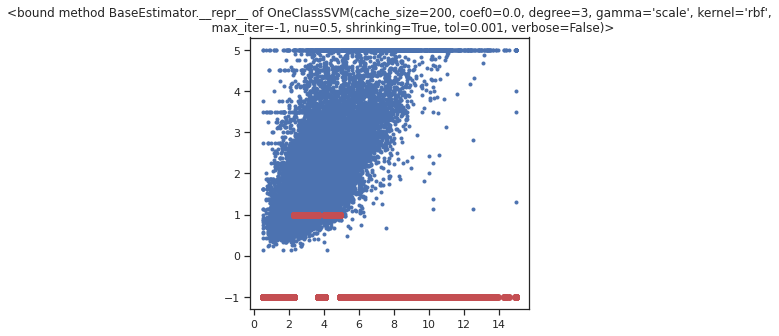

In [67]:
plot_regr(OneClassSVM())

Дерево решений для регрессии

In [0]:
def random_dataset_for_regression():
    """
    Создание случайного набора данных для регрессии
    """
    rng = np.random.RandomState(1)
    X_train = np.sort(5 * rng.rand(80, 1), axis=0)
    y_train = np.sin(X_train).ravel()
    y_train[::5] += 3 * (0.5 - rng.rand(16))
    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    return X_train, y_train, X_test

In [0]:
def plot_tree_regression(X_train, y_train, X_test):
    """
    Построение деревьев и вывод графиков для заданного датасета
    """

    # Обучение регрессионной модели
    regr_1 = DecisionTreeRegressor(max_depth=3)
    regr_2 = DecisionTreeRegressor(max_depth=10)
    regr_1.fit(X_train, y_train)
    regr_2.fit(X_train, y_train)

    # Предсказание
    y_1 = regr_1.predict(X_test)
    y_2 = regr_2.predict(X_test)

    # Вывод графика
    fig, ax = plt.subplots(figsize=(15,7))
    plt.scatter(X_train, y_train, s=20, edgecolor="black", c="darkorange", label="Данные")
    plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=3", linewidth=2)
    plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=10", linewidth=2)
    plt.xlabel("Данные")
    plt.ylabel("Целевой признак")
    plt.title("Регрессия на основе дерева решений")
    plt.legend()
    plt.show()

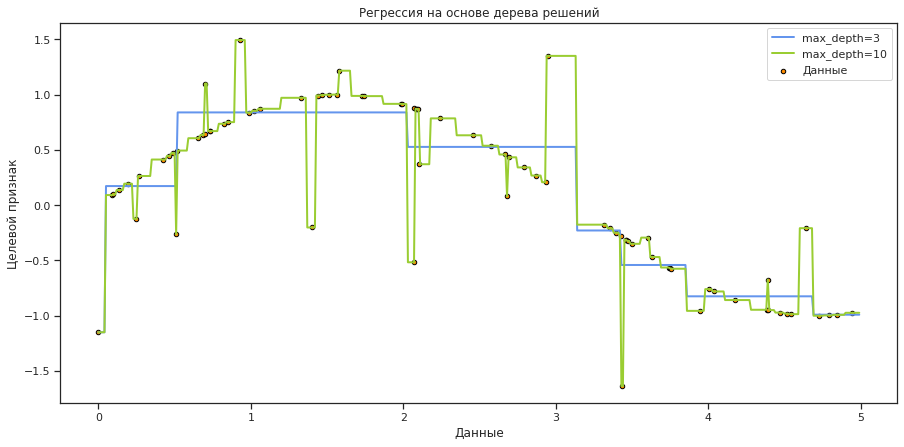

In [70]:
X_train, y_train, X_test = random_dataset_for_regression()
plot_tree_regression(X_train, y_train, X_test)

# **Дерево решений**

In [71]:
california_tree_regr = DecisionTreeRegressor(random_state=1)
california_tree_regr.fit(df_california, data.target)
california_tree_regr

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [0]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0643085 to fit



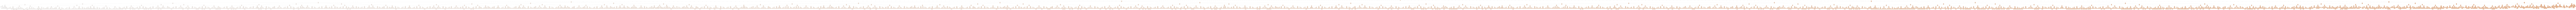

In [73]:
Image(get_png_tree(california_tree_regr, df_california.columns), height="500")

In [74]:
california_tree_regr_prun = DecisionTreeRegressor(random_state=1, max_depth=3)
california_tree_regr_prun.fit(df_california, data.target)
california_tree_regr_prun

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

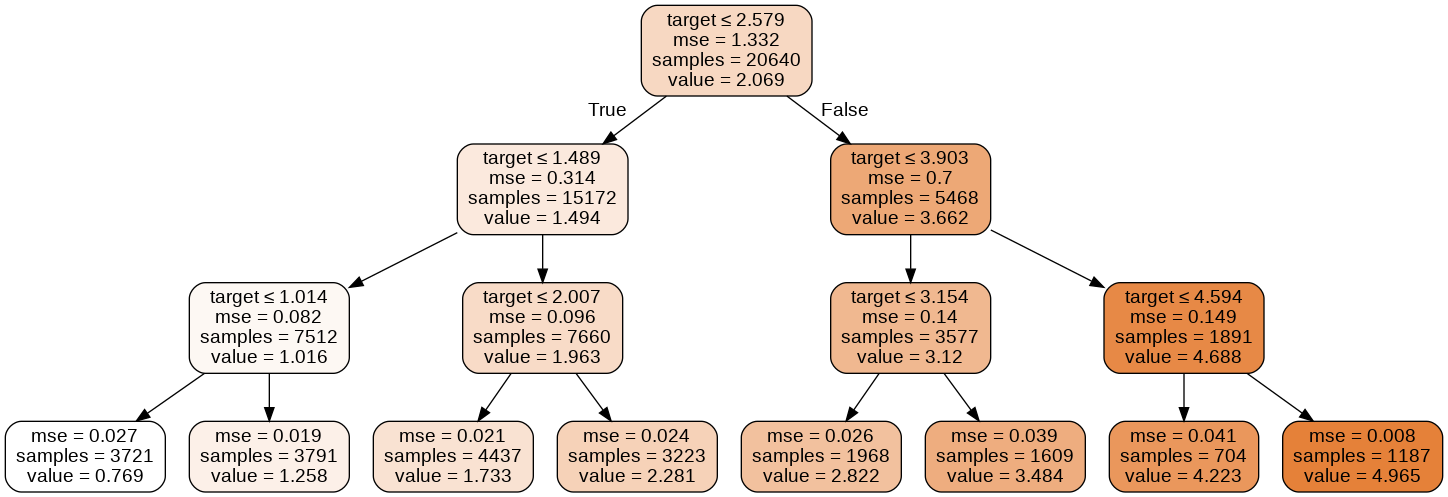

In [75]:
Image(get_png_tree(california_tree_regr_prun, df_california.columns), height="500")

In [76]:
scores_4 = cross_validate(DecisionTreeRegressor(random_state=1, max_depth=3), 
                        sc1_data, df_california['target'], scoring=scoring, 
                        cv=3, return_train_score=True)
scores_4

{'fit_time': array([0.05726457, 0.04353571, 0.03309608]),
 'score_time': array([0.00187492, 0.00159335, 0.00155783]),
 'test_MAE': array([-0.60197332, -0.5610655 , -0.65599163]),
 'test_MSE': array([-0.63497084, -0.5636626 , -0.78360926]),
 'test_R2': array([0.52899805, 0.52830877, 0.45085724]),
 'train_MAE': array([-0.59865069, -0.60456721, -0.55194598]),
 'train_MSE': array([-0.61718838, -0.64270341, -0.56133664]),
 'train_R2': array([0.53105093, 0.54074358, 0.55902855])}

# **Данные метрик дерева решений для сравнения с другими моделями**

In [77]:
-np.mean(scores_4['train_MAE']), -np.mean(scores_4['test_MAE']), \
-np.mean(scores_4['train_MSE']), -np.mean(scores_4['test_MSE']), \
np.mean(scores_4['train_R2']), np.mean(scores_4['test_R2'])

(0.5850546241714393,
 0.6063434807383564,
 0.6070761448129344,
 0.6607475666049402,
 0.5436076857580303,
 0.5027213535306057)

# **Все методы показали примерно одинаковые результаты, однако в целом наилучший результат дала машина опорных векторов**

In [99]:
-np.mean(scores_3['train_MAE']), -np.mean(scores_3['test_MAE']), \
-np.mean(scores_3['train_MSE']), -np.mean(scores_3['test_MSE']), \
np.mean(scores_3['train_R2']), np.mean(scores_3['test_R2'])

(0.5276885217738251,
 0.5502350422781422,
 0.5178224843539592,
 0.5611078368165351,
 0.6103948517000314,
 0.5762820158960761)

In [79]:
-np.mean(scores_2['train_MAE']), -np.mean(scores_2['test_MAE']), \
-np.mean(scores_2['train_MSE']), -np.mean(scores_2['test_MSE']), \
np.mean(scores_2['train_R2']), np.mean(scores_2['test_R2'])

(0.4443838432807796,
 0.507100989083478,
 0.44093920269594206,
 0.5328951447989484,
 0.6682600547769003,
 0.599416311806581)

In [80]:
-np.mean(scores_4['train_MAE']), -np.mean(scores_4['test_MAE']), \
-np.mean(scores_4['train_MSE']), -np.mean(scores_4['test_MSE']), \
np.mean(scores_4['train_R2']), np.mean(scores_4['test_R2'])

(0.5850546241714393,
 0.6063434807383564,
 0.6070761448129344,
 0.6607475666049402,
 0.5436076857580303,
 0.5027213535306057)

# **Подбор одного гиперпараметра**

**Линейная регрессия**

In [121]:
n_range = np.array(range(0,100,5))
tuned_parameters = [{'n_jobs': n_range}]
tuned_parameters

[{'n_jobs': array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
         85, 90, 95])}]

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve

In [122]:
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
reg_gs = GridSearchCV(LinearRegression(), tuned_parameters, cv=ShuffleSplit(), scoring='neg_mean_absolute_error')
reg_gs.fit(data.data, data.target)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_jobs': array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [96]:
reg_gs.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=0, normalize=False)

In [89]:
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

In [98]:
scores_lin_improved = cross_validate(reg_gs.best_estimator_, 
                        sc1_data, df_california['target'], scoring=scoring, 
                        cv=3, return_train_score=True)
scores_lin_improved

{'fit_time': array([0.01382542, 0.00902247, 0.00635958]),
 'score_time': array([0.00205398, 0.00235367, 0.0018456 ]),
 'test_MAE': array([-0.57887213, -0.50877351, -0.56305949]),
 'test_MSE': array([-0.59988822, -0.49188049, -0.59155481]),
 'test_R2': array([0.55502126, 0.58837838, 0.58544641]),
 'train_MAE': array([-0.51394065, -0.54832542, -0.52079949]),
 'train_MSE': array([-0.49933994, -0.54483711, -0.50929041]),
 'train_R2': array([0.62059396, 0.61067588, 0.59991471])}

In [101]:
-np.mean(scores_lin_improved['train_MAE']), -np.mean(scores_lin_improved['test_MAE']), \
-np.mean(scores_lin_improved['train_MSE']), -np.mean(scores_lin_improved['test_MSE']), \
np.mean(scores_lin_improved['train_R2']), np.mean(scores_lin_improved['test_R2'])

(0.5276885217738251,
 0.5502350422781422,
 0.5178224843539592,
 0.5611078368165351,
 0.6103948517000314,
 0.5762820158960761)

Вспоминаем метрики при случайно подобранном гиперпараметре:

In [100]:
-np.mean(scores_3['train_MAE']), -np.mean(scores_3['test_MAE']), \
-np.mean(scores_3['train_MSE']), -np.mean(scores_3['test_MSE']), \
np.mean(scores_3['train_R2']), np.mean(scores_3['test_R2'])

(0.5276885217738251,
 0.5502350422781422,
 0.5178224843539592,
 0.5611078368165351,
 0.6103948517000314,
 0.5762820158960761)

**Для линейной регрессии отличий нет**

**Машина опорных векторов**

In [102]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [103]:
n_range = np.array(range(1,20,1))
tuned_parameters = [{'C': n_range}]
tuned_parameters

[{'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19])}]

In [105]:
reg_gs_svr = GridSearchCV(SVR(), tuned_parameters, cv=3,
                      scoring='neg_mean_absolute_error')
reg_gs_svr.fit(data.data, data.target)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [106]:
reg_gs_svr.best_estimator_

SVR(C=19, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [107]:
scores_svr_improved = cross_validate(reg_gs_svr.best_estimator_, 
                        sc1_data, df_california['target'], scoring=scoring, 
                        cv=3, return_train_score=True)
scores_svr_improved

{'fit_time': array([15.53939581, 16.61715221, 15.49336576]),
 'score_time': array([2.32830477, 2.38654304, 2.32462382]),
 'test_MAE': array([-0.49278758, -0.4468058 , -0.541635  ]),
 'test_MSE': array([-0.52777176, -0.40829368, -0.63635923]),
 'test_R2': array([0.60851505, 0.65832654, 0.55404807]),
 'train_MAE': array([-0.41046405, -0.42600974, -0.40093578]),
 'train_MSE': array([-0.39641595, -0.41509394, -0.38038344]),
 'train_R2': array([0.69879716, 0.70338643, 0.70118067])}

In [108]:
-np.mean(scores_svr_improved['train_MAE']), -np.mean(scores_svr_improved['test_MAE']), \
-np.mean(scores_svr_improved['train_MSE']), -np.mean(scores_svr_improved['test_MSE']), \
np.mean(scores_svr_improved['train_R2']), np.mean(scores_svr_improved['test_R2'])

(0.4124698590661901,
 0.49374279450566805,
 0.3972977772757442,
 0.5241415550388026,
 0.7011214195108509,
 0.6069632218804634)

Данные с произвольным параметром

In [109]:
-np.mean(scores_2['train_MAE']), -np.mean(scores_2['test_MAE']), \
-np.mean(scores_2['train_MSE']), -np.mean(scores_2['test_MSE']), \
np.mean(scores_2['train_R2']), np.mean(scores_2['test_R2'])

(0.4443838432807796,
 0.507100989083478,
 0.44093920269594206,
 0.5328951447989484,
 0.6682600547769003,
 0.599416311806581)

**В целом результат стал лучше для машины опорных векторов**

**Решающее дерево**

In [110]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [111]:
n_range = np.array(range(1,7,1))
tuned_parameters = [{'max_depth': n_range}]
tuned_parameters

[{'max_depth': array([1, 2, 3, 4, 5, 6])}]

In [118]:
reg_gs_dt = GridSearchCV(DecisionTreeRegressor(random_state=1), tuned_parameters,
                          cv=3, scoring='neg_mean_absolute_error')
reg_gs_dt.fit(data.data, data.target)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': array([1, 2, 3, 4, 5, 6])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [120]:
reg_gs_dt.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [123]:
scores_dt_improved = cross_validate(reg_gs_dt.best_estimator_, 
                        sc1_data, df_california['target'], scoring=scoring, 
                        cv=3, return_train_score=True)
scores_dt_improved

{'fit_time': array([0.07014084, 0.06682444, 0.06235528]),
 'score_time': array([0.00182557, 0.00171566, 0.00167012]),
 'test_MAE': array([-0.61119449, -0.49988436, -0.59795421]),
 'test_MSE': array([-0.69455089, -0.47155863, -0.70879242]),
 'test_R2': array([0.48480339, 0.60538437, 0.50328787]),
 'train_MAE': array([-0.45610619, -0.48600847, -0.40178872]),
 'train_MSE': array([-0.40015903, -0.44928409, -0.32800898]),
 'train_R2': array([0.69595312, 0.67895518, 0.74232468])}

In [124]:
-np.mean(scores_dt_improved['train_MAE']), -np.mean(scores_dt_improved['test_MAE']), \
-np.mean(scores_dt_improved['train_MSE']), -np.mean(scores_dt_improved['test_MSE']), \
np.mean(scores_dt_improved['train_R2']), np.mean(scores_dt_improved['test_R2'])

(0.4479677942838462,
 0.5696776857508322,
 0.39248403231981016,
 0.624967314819766,
 0.7057443261913532,
 0.5311585429990194)

Метрики для произвольного параметра:

In [125]:
-np.mean(scores_4['train_MAE']), -np.mean(scores_4['test_MAE']), \
-np.mean(scores_4['train_MSE']), -np.mean(scores_4['test_MSE']), \
np.mean(scores_4['train_R2']), np.mean(scores_4['test_R2'])

(0.5850546241714393,
 0.6063434807383564,
 0.6070761448129344,
 0.6607475666049402,
 0.5436076857580303,
 0.5027213535306057)

В целом результаты для дерева решений стали лучше

# **Итого:**

In [126]:
-np.mean(scores_lin_improved['train_MAE']), -np.mean(scores_lin_improved['test_MAE']), \
-np.mean(scores_lin_improved['train_MSE']), -np.mean(scores_lin_improved['test_MSE']), \
np.mean(scores_lin_improved['train_R2']), np.mean(scores_lin_improved['test_R2'])

(0.5276885217738251,
 0.5502350422781422,
 0.5178224843539592,
 0.5611078368165351,
 0.6103948517000314,
 0.5762820158960761)

In [127]:
-np.mean(scores_svr_improved['train_MAE']), -np.mean(scores_svr_improved['test_MAE']), \
-np.mean(scores_svr_improved['train_MSE']), -np.mean(scores_svr_improved['test_MSE']), \
np.mean(scores_svr_improved['train_R2']), np.mean(scores_svr_improved['test_R2'])

(0.4124698590661901,
 0.49374279450566805,
 0.3972977772757442,
 0.5241415550388026,
 0.7011214195108509,
 0.6069632218804634)

In [128]:
-np.mean(scores_dt_improved['train_MAE']), -np.mean(scores_dt_improved['test_MAE']), \
-np.mean(scores_dt_improved['train_MSE']), -np.mean(scores_dt_improved['test_MSE']), \
np.mean(scores_dt_improved['train_R2']), np.mean(scores_dt_improved['test_R2'])

(0.4479677942838462,
 0.5696776857508322,
 0.39248403231981016,
 0.624967314819766,
 0.7057443261913532,
 0.5311585429990194)

#**Вывод**:
#**Машина опорных векторов показывает наилучшие результаты, на втором месте решающее дерево, на третьем - линейная регрессия.**